# Import

In [1]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout

2025-06-22 15:20:18.282757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 15:20:18.295550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750585818.307949   22235 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750585818.311590   22235 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750585818.321688   22235 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Set memory consumption GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data collection and segmentation

In [4]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [ ]:
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    for file in os.listdir(dir_path):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [ ]:
import cv2
import uuid
import os

ANC_PATH = 'data/anchor'
POS_PATH = 'data/positive'

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = frame[120:120+250, 200:200+250, :]

    k = cv2.waitKey(1) & 0xFF

    if k == ord('a'):
        imgname = os.path.join(ANC_PATH, f'{uuid.uuid4()}.jpg')
        cv2.imwrite(imgname, frame)

    if k == ord('p'):
        imgname = os.path.join(POS_PATH, f'{uuid.uuid4()}.jpg')
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)

    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(400)

I0000 00:00:1750585828.197081   22235 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
anchor.as_numpy_iterator().next()

b'data/anchor/0250887a-8466-4cc8-b96d-73bbe05e783c.jpg'

In [8]:
positive.as_numpy_iterator().next()

b'data/positive/89633021-d97e-47fd-956b-e89c56be4e36.jpg'

# Data preprocessing

In [9]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255.

    return img

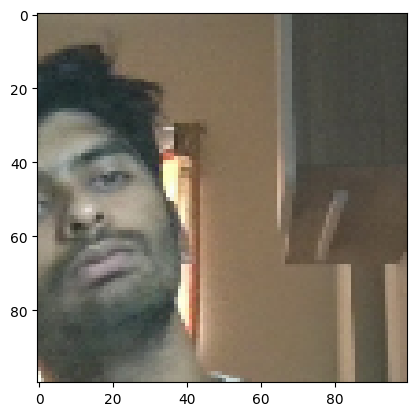

In [10]:
img = preprocess('data/anchor/00a370ec-81a2-4013-a39e-e20a0a92ff65.jpg')
plt.imshow(img)

In [11]:
positive_labels = tf.data.Dataset.from_tensor_slices(tf.ones(400))
negative_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(400))

positives = tf.data.Dataset.zip((anchor, positive, positive_labels))
negatives = tf.data.Dataset.zip((anchor, negative, negative_labels))
data = positives.concatenate(negatives)

In [12]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [13]:
len(data)   # (anchor (400), positive(400), 1) so 400 + (anchor (400), negative(400), 0)

800

In [14]:
data.as_numpy_iterator().next()

(b'data/anchor/07b2fc07-ea43-4cdf-8511-59eaa5d279e6.jpg',
 b'data/positive/a18973dd-f01d-48ec-9151-b781813c1777.jpg',
 1.0)

In [15]:
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [16]:
example = data.as_numpy_iterator().next()

In [17]:
preprocess_twin(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.51740193, 0.48602942, 0.40367648],
         [0.52818626, 0.4968137 , 0.41446078],
         [0.51691175, 0.48553923, 0.40318626],
         ...,
         [0.2637255 , 0.26666668, 0.25      ],
         [0.25808823, 0.26102942, 0.24436274],
         [0.24411765, 0.24803922, 0.2245098 ]],
 
        [[0.5007353 , 0.47034314, 0.39583334],
         [0.51004905, 0.48039216, 0.4014706 ],
         [0.5056372 , 0.48039216, 0.3992647 ],
         ...,
         [0.2637255 , 0.26666668, 0.25      ],
         [0.25808823, 0.2602941 , 0.24583334],
         [0.25514707, 0.25906864, 0.23553921]],
 
        [[0.49264705, 0.46519607, 0.39068627],
         [0.4882353 , 0.46078432, 0.38627452],
         [0.4879902 , 0.46053922, 0.38602942],
         ...,
         [0.26446077, 0.26740196, 0.25073528],
         [0.25514707, 0.25514707, 0.24730392],
         [0.25686276, 0.26078433, 0.24019608]],
 
        ...,
 
        [[0.9843137 , 0.9882353 

In [18]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [19]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [21]:
sample[2]

0.0

In [23]:
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
len(train_data.as_numpy_iterator().next()[0])

16

In [25]:
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

In [26]:
def make_embedding():
    
    inp = Input(shape=(100,100,3),name='input_image')

    c1 = Conv2D(filters=64,kernel_size=(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(pool_size=(2,2),padding='same')(c1)
    c2 = Conv2D(filters=128,kernel_size=(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(pool_size=(2,2),padding='same')(c2)
    c3 = Conv2D(filters=128,kernel_size=(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(pool_size=(2,2),padding='same')(c3)
    c4 = Conv2D(filters=256,kernel_size=(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=inp,outputs=d1,name='embedding')

In [27]:
embedding = make_embedding()

In [28]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#L1 distance (siamese distance) L2 euclidean distance triplet loss

class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [30]:
l1 = L1Dist()

In [31]:
l1

<L1Dist name=l1_dist, built=False>

In [32]:
def make_siamese_model():

    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))

    classifier = Dense(1,activation='sigmoid')(distances)

    return Model(inputs=[input_image,validation_image],outputs=classifier, name='Siamese_Network')

In [33]:
siamese_model = make_siamese_model()

In [34]:
siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [36]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

In [38]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        # ANchor and pos/neg
        X = batch[:2]
        Y = batch[2]

        #Forward pass
        yhat = siamese_model(X, training=True)
        #loss
        loss = binary_cross_loss(Y,yhat)

    grad = tape.gradient(loss,siamese_model.trainable_variables)
    optimizer.apply_gradients(zip(grad,siamese_model.trainable_variables))

    return loss

In [39]:
def train(data,EPOCHS):
    
    for epoch in range(1,EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data),stateful_metrics=['loss'])

        for idx,batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx+1,values=[('loss', loss)])

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCHS = 50
train(train_data,EPOCHS)


 Epoch 1/50


I0000 00:00:1750585898.204022   22351 cuda_dnn.cc:529] Loaded cuDNN version 90300


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2000

 Epoch 2/50
 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0829

2025-06-22 15:21:41.830966: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.1175

 Epoch 3/50
 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0459

2025-06-22 15:21:43.747637: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0156

 Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0325

 Epoch 5/50
 4/40 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0570

2025-06-22 15:21:47.534162: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0410

 Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0174

 Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0034

 Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0071

 Epoch 9/50
 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.5999e-04

2025-06-22 15:21:55.192921: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0132

 Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.8952e-04

 Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0016    

 Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.4884e-04

 Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.2495e-04

 Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.8547e-04

 Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 4.0342e-04

 Epoch 16/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7.4474e-04

 Epoch 17/50
 3/40 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.4478e-04

2025-06-22 15:22:15.409304: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.6569e-04

 Epoch 18/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.9771e-04

 Epoch 19/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.9448e-04

 Epoch 20/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.4245e-05

 Epoch 21/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.5722e-04

 Epoch 22/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.3106e-05

 Epoch 23/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.0332e-04

 Epoch 24/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.7144e-04

 Epoch 25/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.7151e-04

 Epoch 26/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 3.8635e-06

 Epoch 27/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.5526e-05

 Epoch 28/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 6.3815e-05

 Epoch 29/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.5743e-05

 Epoch 30/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.1

2025-06-22 15:22:53.186708: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.5968e-05

 Epoch 34/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.2550e-05

 Epoch 35/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 7.6937e-06

 Epoch 36/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.3016e-06

 Epoch 37/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.2912e-06

 Epoch 38/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.4914e-06

 Epoch 39/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2.4856e-05

 Epoch 40/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 3.0183e-05

 Epoch 41/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 5.0601e-05

 Epoch 42/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 7.0761e-06

 Epoch 43/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.6332e-04

 Epoch 44/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.8791e-05

 Epoch 45/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.9422e-06

 Epoch 46/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.4

In [41]:
from tensorflow.keras.metrics import Precision,Recall

In [42]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [43]:
y_true

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [44]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

I0000 00:00:1750586078.644513   22351 service.cc:152] XLA service 0x7c3a4a4c1730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750586078.644550   22351 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-22 15:24:38.652838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1750586079.666843   22351 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


array([[9.9999905e-01],
       [9.1884361e-10],
       [9.9999583e-01],
       [9.4997382e-08],
       [1.4028395e-06],
       [9.9999774e-01],
       [2.7285088e-08],
       [1.4036136e-08],
       [1.4322266e-06],
       [1.0000000e+00],
       [5.0096216e-05],
       [9.9995553e-01],
       [1.0000000e+00],
       [9.9986994e-01],
       [8.8161542e-08],
       [5.1432894e-06]], dtype=float32)

In [45]:
[1 if i > 0.5 else 0 for i in y_hat]

[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]

In [46]:
m = Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [47]:
p = Precision()
p.update_state(y_true,y_hat)
p.result().numpy()

1.0

In [49]:
y_true[1]

0.0

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    input_image = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))

    best_score = 0
    best_identity = None

    for person_name in os.listdir('application_data/verification_images'):
        person_path = os.path.join('application_data', 'verification_images', person_name)
        results = []

        for image_name in os.listdir(person_path):
            validation_image = preprocess(os.path.join(person_path, image_name))
            input_pair = [np.expand_dims(input_image, axis=0), np.expand_dims(validation_image, axis=0)]
            prediction = model.predict(input_pair)[0][0]
            results.append(prediction)

        detection = np.sum(np.array(results) > detection_threshold)
        verification = detection / len(results)

        if verification > verification_threshold and verification > best_score:
            best_score = verification
            best_identity = person_name

    return best_identity, best_score

In [ ]:
import cv2
import os
import numpy as np
cap = cv2.VideoCapture(0)
while cap.isOpened():

    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    cv2.imshow('Verification', frame)

    if cv2.waitKey(1) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        identity, score = verify(model, detection_threshold=0.9, verification_threshold=0.7)
    
        if identity:
            print(f"✅ Verified as: {identity} with score {score}")
        else:
            print("❌ Verification failed — identity unknown")
    
    if cv2.waitKey(10) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()